In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
#from pyaedt.hfss import Hfss
from ansys.aedt.core import Hfss
import os, copy, pprint, math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.contrib import tenumerate
from tqdm import tqdm

from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))

from functions import *
from devices import *

## Configuration

In [3]:

solution_type = "Modal" # "Eigenmode", "Modal"

# Common options
use_antenna = False
use_second_chip = False

# Eigen mode
min_frequency = "500MHz" # "2GHz"
n_mode = 14
copy_mesh = True
max_passes  = 20

# Driven modal mode
adaptive_solution_type = "single" # single, broadband
start_frequency = 10.0
stop_frequency  = 20.0
medium_frequency = 0.5*(start_frequency + stop_frequency)
adaptive_setup_frequency = medium_frequency
num_of_freq_points = 201
n_waveport_mode = 2

max_delta_s = 0.02

In [4]:
## Sweep flags
## Add variables to the sweep_list to activate parameter sweeps defined in the sweep_config
if solution_type == "Eigenmode":
    sweep_list = [ "$chip_inductance" ]
else:
    sweep_list = [
        "$chip_theta",
        "$chip_pos_z_ratio",
    ]

if len(sweep_list) == 0:
    no_variation = False
else:
    no_variation = True

sweep_config = {
    "$chip_inductance" : [
        dict(start_point = 1.25, end_point = 3, step = 0.25, units = "nH", variation_type="LinearStep"),
        dict(start_point = 0.4, end_point = 1, step = 0.05, units = "nH", variation_type="LinearStep"),
    ],
    "$chip_theta" : [
        # dict(start_point = 0, end_point = 0, step = 1, units = "deg", variation_type="LinearCount"),
        dict(start_point = -90, end_point = 45, step = 4, units = "deg", variation_type="LinearCount"),
    ],
    "$chip_gap" : [
        dict(start_point = 20, end_point = 520, step = 100, units = "um", variation_type="LinearStep"),
        dict(start_point = 1020, end_point = 2020, step = 500, units = "um", variation_type="LinearStep"),
    ],
    "$chip_width" : [
        dict(start_point = 100, end_point = 1000, step = 150, units = "um", variation_type="LinearStep"),
        dict(start_point = 1500, end_point = 3000, step = 500, units = "um", variation_type="LinearStep"),
    ],
    "$chip_pos_z_ratio" : [
        dict(start_point = 0.4, end_point = 0.8, step = 0.1, units = None, variation_type="LinearStep"),
    ],
    "$chip_height" : [
        dict(start_point = 500, end_point = 3000, step = 500, units = "um", variation_type="LinearStep"),
    ],   
    "$outer_radius" : [
        dict(start_point = 5, end_point = 15, step = 6, units = "mm", variation_type="LinearCount"),
    ],   
    "$outer_height" : [
        dict(start_point = 18, end_point = 38, step = 2, units = "mm", variation_type="LinearStep"),
    ],   
    "$coax_height" : [
        dict(start_point = 9, end_point = 38, step = 3, units = "mm", variation_type="LinearCount"),
    ],   
}

## Make project and design

In [5]:
hfss = Hfss(
    project       = "test.aedt",
    design        = "A1",
    solution_type = solution_type
)
hfss.logger.logger.setLevel("WARNING")
hfss.modeler.logger.logger.setLevel("WARNING")

PyAEDT INFO: Python version 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:39:58) [MSC v.1943 64 bit (AMD64)].
PyAEDT INFO: PyAEDT version 0.17.4.
PyAEDT INFO: Initializing new Desktop session.
PyAEDT INFO: Log on console is enabled.
PyAEDT INFO: Log on file C:\Users\ymino\AppData\Local\Temp\15\pyaedt_ymino_eecaf165-9b42-4c38-ab47-555ffb4878f0.log is enabled.
PyAEDT INFO: Log on AEDT is disabled.
PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.
PyAEDT INFO: Launching PyAEDT with gRPC plugin.
PyAEDT ERROR: A(n) <class 'psutil.AccessDenied'> error occurred while retrieving information for the active AEDT sessions: (pid=11984, name='ansysedt.exe')
PyAEDT ERROR: A(n) <class 'psutil.AccessDenied'> error occurred while retrieving information for the active AEDT sessions: (pid=13016, name='ansysedt.exe')
PyAEDT ERROR: A(n) <class 'psutil.AccessDenied'> error occurred while retrieving information for the active AEDT sessions: (pid=16452, name='ansysedt.exe'

In [6]:
# Best configuration
# degree : 0, chip gap : 2000 um, chip width : 500 um, chip height : 800 um , pos_z_ratio : 0.7 (-7.5 dB between 12 - 20 GHz)
# degree : 0, chip gap : 500 um , chip width : 500 um, chip height : 1600 um, pos_z_ratio : 0.7 (-6.7 dB between 12 - 20 GHz)

# nominal : 12.6 GHz, L = 1.4 nH

# 8.6  GHz, L = 30   nH, chip_gap = 2000 um, chip_width = 250 um, chip_height = 400 um
# 10.4 GHz, L = 20   nH, chip_gap = 2000 um, chip_width = 250 um, chip_height = 400 um
# 11.7 GHz, L = 15   nH, chip_gap = 2000 um, chip_width = 250 um, chip_height = 400 um
# 12.1 GHz, L = 13.5 nH, chip_gap = 2000 um, chip_width = 250 um, chip_height = 400 um
# 12.6 GHz, L = 13   nH, chip_gap = 2000 um, chip_width = 250 um, chip_height = 400 um
# 12.8 GHz, L = 12.5 nH, chip_gap = 2000 um, chip_width = 250 um, chip_height = 400 um
# 14.1 GHz, L = 10   nH, chip_gap = 2000 um, chip_width = 250 um, chip_height = 400 um

#  ? GHz, L = 30 nH, chip_gap = 8000 um, chip_width = 250 um, chip_height = 400 um

#  19 GHz, L = 9 nH, chip_gap = 20 um, chip_width = 250 um, chip_height = 4000 um

hfss["$outer_radius"]         = "8mm" # 5mm, 8mm (for 10GHz cut-off)
hfss["$outer_height"]         = "38mm" # 38mm
hfss["$coax_radius"]          = "1.5mm" # "1.5mm"
hfss["$coax_height"]          = "9mm"
hfss["$antenna_height"]       = "18mm"
hfss["antenna_radius"]        = "1.5mm"
hfss["$antenna_outer_height"] = "8mm"
hfss["antenna_outer_radius"]  = "3mm"
hfss["$chip_inductance"]      = "1.4nH"
hfss["$chip_gap"]             = "220um" # 20um
hfss["$chip_width"]           = "250um" # 250um
hfss["$chip_height"]          = "2000um" # 400um (For chip_gap = 20um, galvanic with 3240 ( ~4500 with 45 degree ? ) )
hfss["$chip_theta"]           = "0deg" # 0deg
hfss["$chip_pos_z_ratio"]     = "0.6"
hfss["$chip_pos_z"]           = "$chip_pos_z_ratio*$coax_height"
hfss["$chip_pos_y"]           = "$coax_radius + 0.5*($outer_radius - $coax_radius)"
hfss["$wafer_thickness"]      = "0.525mm"
hfss["$wafer_width"]          = "2mm"
hfss["$wafer_height"]         = "6mm"
hfss["box_height"]            = "40mm"
hfss["$box_length"]           = "2*$outer_radius + 10mm" #"15mm"

In [7]:
box_config = dict(
    origin   = ["-$box_length/2", "-$box_length/2", "$outer_height - box_height"],
    sizes    = ["$box_length", "$box_length", "box_height"],
    name     = "box",
    material = "copper"
)
if use_antenna:
    box_config.update( sizes = ["$box_length", "$box_length", "box_height + $antenna_outer_height"] )

box_object = hfss.modeler.create_box( **box_config )

## Make Vacuum object
#_, vacuum_name = hfss.modeler.duplicate_around_axis(box_object, "Z", angle = 0)
vacuum_object = box_object.clone()
vacuum_object.name = "boundary"
vacuum_object = hfss.modeler.get_object_from_name("boundary")
hfss.assign_material("boundary", "vacuum")
if solution_type == "Eigenmode":
    # hfss.modeler.move_face([vacuum_object.top_face_z], offset=20) # offset in mm
    hfss.assign_finite_conductivity([vacuum_object.top_face_z],is_infinite_ground=True)

In [8]:
cylinder_config = dict(
    orientation = "Z",
    origin      = [0, 0, 0],
    radius      = "$outer_radius",
    height      = "$outer_height",
    name        = "outer",
    material    = "vacuum"
)

cylinder_object = hfss.modeler.create_cylinder( **cylinder_config )

In [9]:
box_object.subtract(cylinder_object, keep_originals=False)

In [10]:
cylinder_config = dict(
    orientation = "Z",
    origin      = [0, 0, 0],
    radius      = "$coax_radius",
    height      = "$coax_height",
    name        = "coax",
    material    = "copper"
)

coax_object = hfss.modeler.create_cylinder( **cylinder_config )

In [11]:
box_object.unite(coax_object)

## Create antenna

In [12]:
if use_antenna:
    antenna_config = dict(
        orientation = "Z",
        origin      = [0, 0, "$outer_height"],
        radius      = "antenna_outer_radius",
        height      = "$antenna_outer_height",
        name        = "antenna",
        material    = "vacuum"
    )

    antenna_object = hfss.modeler.create_cylinder( **antenna_config )
    box_object.subtract(antenna_object, keep_originals=False)

    antenna_config = dict(
        orientation = "Z",
        origin      = [0, 0, "$outer_height + $antenna_outer_height - $antenna_height"],
        radius      = "antenna_radius",
        height      = "$antenna_height",
        name        = "core",
        material    = "copper"
    )

    core_object = hfss.modeler.create_cylinder( **antenna_config )

## Create wafer

In [13]:
wafer_coord = hfss.modeler.create_coordinate_system(origin = [0, "$chip_pos_y","$chip_pos_z"], name = "wafer_coord")
wafer_coord.set_as_working_cs()
wafer_config = dict(
    origin   = ["-$wafer_width/2", "-$wafer_height/2", 0],
    sizes    = ["$wafer_width", "$wafer_height", "$wafer_thickness"],
    name     = "wafer",
    material = "silicon"
)
wafer_object = hfss.modeler.create_box( **wafer_config )

## Create chip

In [14]:
chip_coord = hfss.modeler.create_coordinate_system(origin = [0, 0,"$wafer_thickness"], reference_cs="wafer_coord", name = "chip_coord")
chip_coord.set_as_working_cs()
cap1 = hfss.modeler.create_rectangle(origin = ["-0.5*$chip_width", "0.5*$chip_gap", 0], sizes = ["$chip_width", "$chip_height"], name = "cap1", orientation="XY")
cap2 = hfss.modeler.create_rectangle(origin = ["-0.5*$chip_width", "-0.5*$chip_gap - $chip_height", 0], sizes =  ["$chip_width", "$chip_height"], name = "cap2", orientation="XY")

In [15]:
## Only for newer pyaedt versions ?
hfss.assign_perfect_e("box")
hfss.assign_perfect_e("cap1")
hfss.assign_perfect_e("cap2")
if use_antenna:
    hfss.assign_perfect_e("core")

## Create ports

In [16]:
# faces = vacuum_object.faces
# top_face = max(faces, key=lambda f: f.center[2])

In [17]:
hfss.modeler.set_working_coordinate_system("Global")
if solution_type=="Modal":
    if use_antenna:
        port_in = hfss.modeler.create_circle(origin = [0, 0, "$outer_height + $antenna_outer_height"], radius = "antenna_outer_radius", name = "port_in", orientation="XY")
        hfss.lumped_port(assignment="port_in", integration_line = hfss.AxisDir.YNeg, name="Port_in")
    else:
        port_in = hfss.modeler.create_circle(origin = [0, 0, "$outer_height"], radius = "$outer_radius", name = "port_in", orientation="XY")
        hfss.wave_port(assignment="port_in", name = "Port_in", modes = n_waveport_mode)

hfss.modeler.set_working_coordinate_system("chip_coord")
port_out = hfss.modeler.create_rectangle(origin = ["-10um","-0.5*$chip_gap" ], sizes=["20um","$chip_gap"], name = "port_out", orientation="XY")
if solution_type=="Eigenmode":
    sheet = hfss.assign_lumped_rlc_to_sheet(assignment="port_out", 
                                    start_direction=hfss.AxisDir.YNeg, 
                                    inductance=9e-9, name="Port_out")
    sheet.update_property(
        prop_name = "Inductance",
        prop_value = "$chip_inductance"
    )
else:
    # hfss.assign_lumped_rlc_to_sheet(assignment="port_out", start_direction=hfss.AxisDir.YNeg, inductance=chip_inductance, name="Port_out")
    hfss.lumped_port(assignment="port_out", integration_line = hfss.AxisDir.YNeg, name="Port_out")

## Rotate chip

In [18]:
# rotate_coord = hfss.modeler.create_coordinate_system(origin = [0, "-0.5*$chip_gap - $chip_height", 0], reference_cs="chip_coord", name = "rotate_coord")
# rotate_coord.set_as_working_cs()
hfss.modeler.set_working_coordinate_system("chip_coord")
hfss.modeler.rotate(assignment=["wafer","cap1","cap2","port_out"], axis="X", angle="$chip_theta")

True

In [19]:
if use_second_chip:
    hfss.modeler.set_working_coordinate_system("Global")
    duplicate_object = ["wafer","cap1","cap2","port_out"]
    _, object_name = hfss.modeler.duplicate_around_axis(duplicate_object, "Z", angle = 90)
    for i, obj_name in enumerate(duplicate_object):
        obj = hfss.modeler.get_object_from_name(object_name[i])
        obj.name = f"chip2_{obj_name}"
    # cap1_object = hfss.modeler.get_object_from_name(object_name[0])
    # cap1_object.name = "chip2_cap1"
    # cap2_object = hfss.modeler.get_object_from_name(object_name[1])
    # cap2_object.name = "chip2_cap2"
    # port_object = hfss.modeler.get_object_from_name(object_name[2])
    # port_object.name = "chip2_port_out"

## Assign mesh operation

In [20]:
hfss.mesh.assign_length_mesh(["cap1", "cap2"], inside_selection=False, maximum_length="20um", name="mesh_cap")
hfss.mesh.assign_length_mesh(["port_out"], inside_selection=False, maximum_length="5um", name="mesh_JJ") # maximum 7um for JJ in qiskit-metal
if use_second_chip:
    hfss.mesh.assign_length_mesh(["chip2_cap1","chip2_cap2"], inside_selection=False, maximum_length="20um", name="mesh_cap2")
    hfss.mesh.assign_length_mesh(["chip2_port_out"], inside_selection=False, maximum_length="5um", name="mesh_JJ")

## Create Analysis Setup

In [21]:
# if solution_type=="Modal":
#     hfss.create_open_region(Frequency="1GHz")

if solution_type=="Modal":

    setup = hfss.create_setup("MySetup")
    setup.create_frequency_sweep(
        unit="GHz",
        name="Sweep1",
        start_frequency=start_frequency,
        stop_frequency=stop_frequency,
        num_of_freq_points=num_of_freq_points,
        sweep_type="Interpolating",
    )
    if adaptive_solution_type == "broadband":
        setup.enable_adaptive_setup_broadband(
            low_frequency=start_frequency,
            high_frquency=stop_frequency,
            max_passes=max_passes,
            max_delta_s=max_delta_s
        ) 
    elif adaptive_solution_type == "single":
        setup.enable_adaptive_setup_single(
            freq=adaptive_setup_frequency,
            max_passes=max_passes,
            max_delta_s=max_delta_s
        )
        # setup.props["MaximumPasses"] = 20
        # setup.props["MaxDeltaS"] = 0.01
    pprint.pprint(setup.props)

{'BasisOrder': 1,
 'DoLambdaRefine': True,
 'DoMaterialLambda': True,
 'Frequency': '15.0GHz',
 'IE Solver Accuracy': 'Balanced',
 'IESolverType': 'Auto',
 'IsEnabled': True,
 'LambdaTargetForIESolver': 0.15,
 'MaxDeltaS': 0.02,
 'MaximumPasses': 20,
 'MeshLink': {'ImportMesh': False},
 'MinimumConvergedPasses': 1,
 'MinimumPasses': 1,
 'MultipleAdaptiveFreqsSetup': {'1GHz': [0.02], '2GHz': [0.02], '5GHz': [0.02]},
 'Name': 'MySetup',
 'PercentRefinement': 30,
 'PortAccuracy': 2,
 'PortsOnly': False,
 'SaveAnyFields': True,
 'SaveRadFieldsOnly': False,
 'SetLambdaTarget': False,
 'SetPortMinMaxTri': False,
 'SolveType': 'Single',
 'Target': 0.3333,
 'UseABCOnPort': False,
 'UseDefaultLambdaTgtForIESolver': True,
 'UseDomains': False,
 'UseIterativeSolver': False,
 'UseMatrixConv': False,
 'UseMaxTetIncrease': False}


In [22]:
if solution_type=="Eigenmode":
    setup = hfss.create_setup("MySetup") 
    setup.props["MinimumFrequency"] = min_frequency
    setup.props["NumModes"]         = n_mode
    setup.props["MaximumPasses"]    = max_passes
    pprint.pprint(setup.props)

## Optemtrics

In [23]:
sweep = None
for var in sweep_list:
    sweep = add_sweep(hfss, sweep, sweep_config, var)



## Analyze

In [24]:
if not no_variation:
    hfss.analyze_setup(name = "MySetup", cores=8)
else:
    ## You can check the available properties
    # print(sweep.props)
    ## If you want to enable SaveFields & CopyMesh, you need to directly rewrite the properties using the dictionary
    # hfss.set_oo_property_value(
    #     aedt_object=hfss.ooptimetrics, 
    #     object_name="ChipInductance", 
    #     prop_name='SaveFields', 
    #     value='True')
    print(sweep)
    sweep.props["ProdOptiSetupDataV2"]["SaveFields"] = True
    if solution_type == "Eigenmode":
        sweep.props["ProdOptiSetupDataV2"]["CopyMesh"] = copy_mesh
    sweep.analyze(cores = 8)

## Produce Report

In [25]:
if solution_type == "Modal":
    report_config = dict(
        expressions=["db(S12)"], 
        #expressions=["db(S(Port_out,Port_in))","db(S(Port_out1,Port_in))"], 
        plot_name="S-parameter", 
        variations={
            "Freq": ["All"],
        }
    )
    if n_waveport_mode >= 2:
        expressions = []
        for i in range(n_waveport_mode):
            expressions.append(f"db(S(Port_out,Port_in:{i+1}))")
        report_config.update(
            expressions = expressions
        )
else:
    report_config = dict(
        # expressions=["Mode(1)","Mode(2)","Mode(3)"], 
        plot_name="Eigen modes", 
        variations={}
    )

# Add variations to report_config
for var in sweep_list:
    report_config["variations"][var] = ["All"]

report = hfss.post.create_report( **report_config )

In [26]:
# traces_to_plot = hfss.get_traces_for_plot()
# report = hfss.post.create_report(traces_to_plot)  # Creates a report in HFSS
# solution = report.get_solution_data()
# solution.plot(solution.expressions[1])  # Matplotlib axes object.

['db(S(Port_out,Port_in:1))', 'db(S(Port_out,Port_in:2))']
[{'$chip_theta': -1.570796326794897deg, '$chip_pos_z_ratio': 0.4}, {'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.4}, {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.4}, {'$chip_theta': 0.7853981633974483deg, '$chip_pos_z_ratio': 0.4}, {'$chip_theta': -1.570796326794897deg, '$chip_pos_z_ratio': 0.5}, {'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.5}, {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.5}, {'$chip_theta': 0.7853981633974483deg, '$chip_pos_z_ratio': 0.5}, {'$chip_theta': -1.570796326794897deg, '$chip_pos_z_ratio': 0.6}, {'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.6}, {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.6}, {'$chip_theta': 0.7853981633974483deg, '$chip_pos_z_ratio': 0.6}, {'$chip_theta': -1.570796326794897deg, '$chip_pos_z_ratio': 0.7}, {'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.7}, {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.7}, {'$chip_theta'

100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\ymino\AppData\Local\Temp\15\ipykernel_29892\2417895319.py:78: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(freq_list, mode_S_array[id], marker = ".", label = var.values())


-6.507315485987448 {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.6}
-6.570867477008803 {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.7}
-6.66300987235254 {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.5}
-7.074272056116597 {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.4}
-7.332034097582009 {'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.8}
-7.847704049116209 {'$chip_theta': 0.7853981633974483deg, '$chip_pos_z_ratio': 0.6}
-8.074044961031719 {'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.5}
-8.153452192544114 {'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.6}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

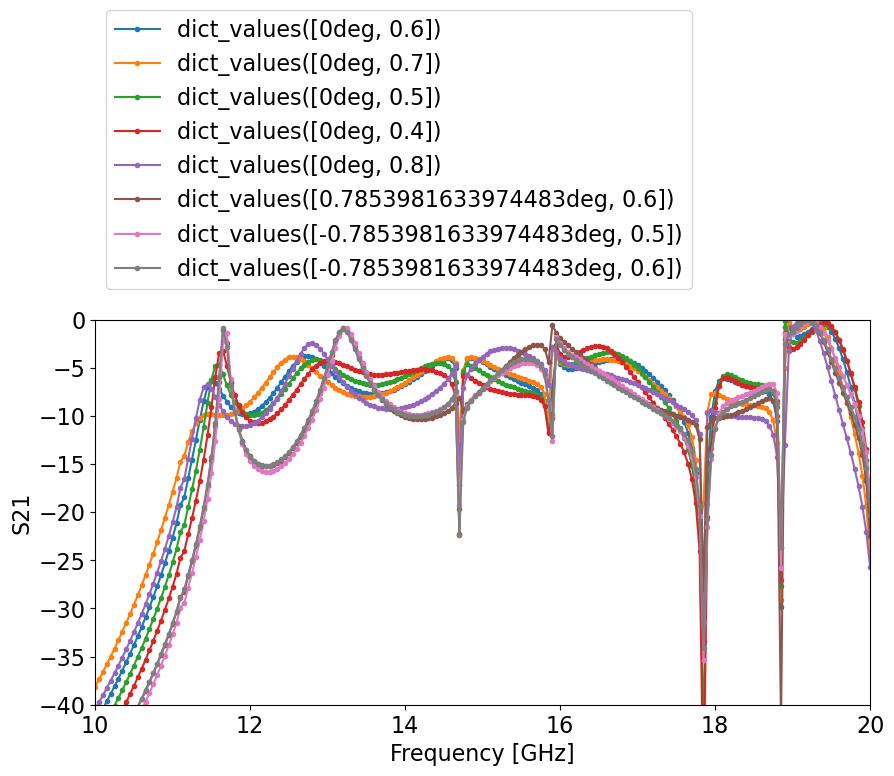

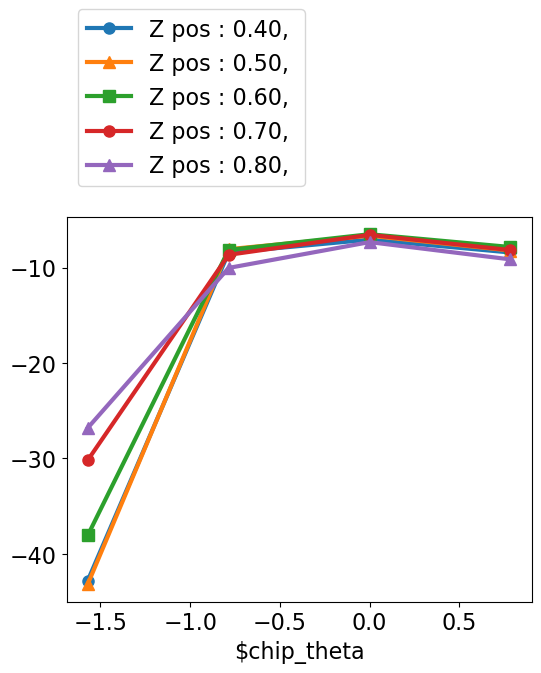

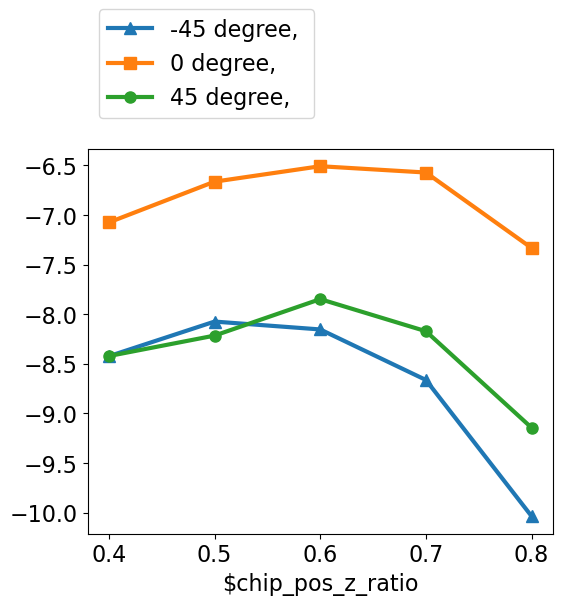

In [38]:
if solution_type == "Modal":
    expressions=["db(S(Port_out,Port_in))"]
    
    # report = hfss.post.reports_by_category.eigenmode(expressions=expressions)
    solution_data = report.get_solution_data()
    solution_data.export_data_to_csv(output="output/CoaxCavity_Modal.csv")
    # Get S21 data
    print(report.expressions)

    # Get frequency list
    freq_list = [ i.value for i in solution_data.variation_values(variation="Freq") ]

    if not no_variation:
        S = solution_data.data_real()
        plt.figure(figsize=(10,5))
        plt.subplot(111, xlabel = "Frequency [GHz]", ylabel = "S21")
        plt.plot(freq_list, S, marker = ".")
        plt.xlim(5,20)
        plt.ylim(-50,0)
    else:
        print(solution_data.variations)
        mode_S_array = np.zeros(shape=(len(solution_data.variations), len(freq_list)))
    

        # First retrieve all information
        if n_waveport_mode == 2:
            # If there are two modes, add S-parameters
            for id in tqdm(range(len(solution_data.variations))):
                solution_data.set_active_variation(id)
                power_array = np.zeros(shape=(1, len(freq_list)))
                for expr in report.expressions:
                    # print(id, expr, solution_data.data_real(expression=expr))
                    power_array += np.power(10, 0.1*np.array(solution_data.data_real(expression=expr)))
                mode_S_array[id] = 10*np.log10(power_array)
        else:
            for id in tqdm(range(len(solution_data.variations))):
                solution_data.set_active_variation(id)
                mode_S_array[id] = solution_data.data_real()

        # plt.figure(figsize=(10,5))
        # plt.subplot(111, xlabel = "Frequency [GHz]", ylabel = "S21")
        # for id, var in enumerate(solution_data.variations):
        #     plt.plot(freq_list, mode_S_array[id], marker = ".", label = var.values())
        # plt.xlim(10,20)
        # plt.ylim(-70,0)
        # plt.legend(loc = "lower right")

        # Find variation with least loss between 12 ~ 20 GHz
        average_list = []
        # for id, var in enumerate(solution_data.variations):
        for id, var in tenumerate(solution_data.variations):
            total = 0
            point = 0
            for freq, S21 in zip(freq_list, mode_S_array[id]):
                if 12 < freq and freq < 20:
                    total += S21
                    point += 1
            average = float(total/point)
            average_list.append(average)

        # max_index = np.argmax(average_list)
        # print(average_list[max_index])
        # print(solution_data.variations[max_index])

        num = 8 # Number of variations to show

        sorted_indices = sorted(range(len(average_list)), key=lambda i: average_list[i], reverse=True)
        for i, id in enumerate(sorted_indices):
            print(average_list[id], solution_data.variations[id])
            if i == num - 1:
                break

        plt.figure(figsize=(10,5))
        plt.subplot(111, xlabel = "Frequency [GHz]", ylabel = "S21")

        for i, id in enumerate(sorted_indices):
            var = solution_data.variations[id]
            plt.plot(freq_list, mode_S_array[id], marker = ".", label = var.values())
            if i == num - 1:
                break
        plt.xlim(10,20)
        plt.ylim(-40,0)
        plt.legend( bbox_to_anchor=(0., 1.05), loc = "lower left")

        for x_var in solution_data.variations[0]:
            x = {}
            y = {}
            for id, vars in tenumerate(solution_data.variations):  
                key = ""
                for var in vars:
                    if var == x_var:
                        x_value = vars[x_var].value
                    else:
                        key += rename_var(vars, var) + ", "
                if key not in x:
                    x[key] = []
                    y[key] = []
                # x[key].append( pos_z_ratio )
                x[key].append( x_value )
                y[key].append( average_list[id] )

            # Use the list to select top rows
            top_keys = []
            for i, id in enumerate(sorted_indices):
                vars = solution_data.variations[id]
                key = ""
                for var in vars:
                    if var == x_var:
                        pass
                    else:
                        key += rename_var(vars, var)  + ", "
                top_keys.append(key)
                if i == num - 1:
                    break

            plt.rcParams["font.size"] = 16
            plt.figure(figsize=(6,5))

            marker_map = [
                'o', '^', 's'
            ]
            for i, key in enumerate(x):
                if key in top_keys:
                    plt.plot(x[key], y[key], marker = marker_map[i%3], label = key, linewidth=3, markersize=8)
                    plt.xlabel(x_var)
            # plt.ylim(-30,0)
            # plt.legend(loc = "lower left", fontsize="large")
            plt.legend( bbox_to_anchor=(0, 1.05), loc='lower left' )
            plt.savefig('output/sweep_' + x_var.replace('$','') + '.png', bbox_inches='tight')

In [28]:
solution_data = report.get_solution_data()
for id in range(len(solution_data.variations)):
    print(solution_data.variations[id])
    solution_data.set_active_variation(id)

{'$chip_theta': -1.570796326794897deg, '$chip_pos_z_ratio': 0.4}
{'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.4}
{'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.4}
{'$chip_theta': 0.7853981633974483deg, '$chip_pos_z_ratio': 0.4}
{'$chip_theta': -1.570796326794897deg, '$chip_pos_z_ratio': 0.5}
{'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.5}
{'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.5}
{'$chip_theta': 0.7853981633974483deg, '$chip_pos_z_ratio': 0.5}
{'$chip_theta': -1.570796326794897deg, '$chip_pos_z_ratio': 0.6}
{'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.6}
{'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.6}
{'$chip_theta': 0.7853981633974483deg, '$chip_pos_z_ratio': 0.6}
{'$chip_theta': -1.570796326794897deg, '$chip_pos_z_ratio': 0.7}
{'$chip_theta': -0.7853981633974483deg, '$chip_pos_z_ratio': 0.7}
{'$chip_theta': 0deg, '$chip_pos_z_ratio': 0.7}
{'$chip_theta': 0.7853981633974483deg, '$chip_pos_z_ratio': 0.7}
{'$chip_theta': -1.57079

In [29]:
if solution_type == "Eigenmode":
    # report = hfss.post.reports_by_category.eigenmode(expressions=expressions)
    solution_data = report.get_solution_data()
    solution_data.export_data_to_csv(output="output/CoaxCavity_Eigenmode.csv")

    max_freq_list = []
    max_Q_list = []
    next_freq_list = []
    next_Q_list = []
    mode_freq_array = np.zeros(shape=(len(report.expressions), len(solution_data.variations)))
    mode_Q_array = np.zeros(shape=(len(report.expressions), len(solution_data.variations)))

    # First retrieve all information
    for id in range(len(solution_data.variations)):
         solution_data.set_active_variation(id)
         for imode, mode in enumerate(report.expressions):
            freq = solution_data.data_real(mode)[0]
            Q = abs(0.5 * freq / solution_data.data_imag(mode)[0])
            # if solution_data.data_imag(mode)[0] > 0:
            #     Q = abs(0.5 * freq / solution_data.data_imag(mode)[0])
            # else:
            #     Q = 1e+11
            mode_freq_array[imode][id] = freq
            mode_Q_array[imode][id] = Q
    # Get unrelated mode info
    if copy_mesh:
        tol = 0.1e+9
    else:
        tol = 0.05e+9
    flat = mode_freq_array.flatten()
    groups = []
    averages = []
    used = set()

    min_count = int(0.8*len(solution_data.variations))
    for i, val in enumerate(flat):
        if i in used:
            continue
        close_idx = np.where(np.abs(flat - val) <= tol)[0]
        if len(close_idx) >= min_count:  # 指定回数以上出現した場合のみ
            group_vals = flat[close_idx]
            avg = np.mean(group_vals)
            groups.append(group_vals.tolist())
            averages.append(avg)
            used.update(close_idx)

    print("average:")
    pprint.pprint(averages)

    if not no_variation:
        pass
    else:
        for id in range(len(solution_data.variations)):
            #print(solution_data.variations[id])
            solution_data.set_active_variation(id)

            max_Q = 1
            max_freq = 1
            next_Q = 1
            next_freq = 1
            for imode, mode in enumerate(report.expressions):
                freq = solution_data.data_real(mode)[0]
                Q = abs(0.5 * freq / solution_data.data_imag(mode)[0])
                # if solution_data.data_imag(mode)[0] > 0:
                #     Q = abs(0.5 * freq / solution_data.data_imag(mode)[0])
                # else:
                #     Q = 1e+11
                if any(np.abs(np.array(averages) - freq) <= tol):
                    continue
                if Q > max_Q:
                    next_Q = copy.copy(max_Q)
                    next_freq = copy.copy(max_freq)
                    max_Q = copy.copy(Q)
                    max_freq = copy.copy(freq)
                elif Q > next_Q:
                    next_Q = copy.copy(Q)
                    next_freq = copy.copy(freq)

            max_freq_list.append(max_freq)
            max_Q_list.append(max_Q)
            next_freq_list.append(next_freq)
            next_Q_list.append(next_Q)
            # print("Max  Frequency : ",max_freq*1e-9, " [GHz]")
            # print("Max  Q-value   : ",max_Q*1e-6, "M")
            # print("Next Frequency : ",next_freq*1e-9, " [GHz]")
            # print("Next Q-value   : ",next_Q*1e-6, "M")


        variation_list = []
        for my_dict in solution_data.variations:
            new_list = [ i.value for i in list(my_dict.values()) ]
            variation_list.extend(new_list)

        # Make plots
        variation_list = np.array(variation_list)
        max_freq_list = np.array(max_freq_list)
        next_freq_list = np.array(next_freq_list)
        max_Q_list = np.array(max_Q_list)
        next_Q_list = np.array(next_Q_list)
        max_lifetime_list = 2*max_Q_list/max_freq_list
        next_lifetime_list = 2*next_Q_list/next_freq_list
        plt.figure(figsize=(15,10))
        plt.subplot(231, xlabel = "Inductance [nH]", ylabel = "Frequency [GHz]")
        for imode, mode in enumerate(report.expressions):
            plt.plot(variation_list*1e9, mode_freq_array[imode]*1e-9, marker = ".")
        plt.xscale('log')

        plt.subplot(232, xlabel = "Inductance [nH]", ylabel = "Q value")
        for imode, mode in enumerate(report.expressions):
            plt.plot(variation_list*1e9, mode_Q_array[imode], marker = ".")
        plt.yscale('log')
        plt.xscale('log')

        plt.subplot(234, xlabel = "Inductance [nH]", ylabel = "Frequency [GHz]")
        plt.plot(variation_list*1e9, max_freq_list*1e-9, marker=".", linestyle='None')
        #plt.plot(variation_list*1e9, next_freq_list*1e-9, marker=".")
        plt.xscale('log')

        plt.subplot(235, xlabel = "Frequency [GHz]", ylabel = "Q Value")
        plt.plot(max_freq_list*1e-9, max_Q_list, marker=".", linestyle='None')
        #plt.plot(next_freq_list*1e-9, next_Q_list, marker=".")
        plt.yscale('log')

        plt.subplot(236, xlabel = "Frequency [GHz]", ylabel = "Lifetime [us]")
        plt.plot(max_freq_list*1e-9, max_lifetime_list*1e6, marker=".", linestyle='None')
        #plt.plot(next_freq_list*1e-9, next_Q_list, marker=".")
        plt.yscale('log')

In [30]:
## Get intrinsic information (First you need the solution frequency)
intrinsics = hfss.setups[0].default_intrinsics
print(intrinsics)
print(hfss.setups)
solution = hfss.setups[0].get_solution_data()
# intrinsics["Freq"] = hfss.setups[0].properties["Solution Freq"]

{'Freq': '15.0GHz', 'Phase': '0deg'}
[MySetup with 2 Sweeps]


In [31]:
## Plot field (Currently disabled)
# cutlist = ["Global:YZ"]
# setup_name = hfss.existing_analysis_sweeps[0]
# #setup_name = "Sweep1"
# quantity_name = "Mag_E"
# intrinsic = {"Freq": "5GHz", "Phase": "0deg"}
# hfss.logger.info("Generating the image")
# plot_obj = hfss.post.plot_field(
#         quantity="Mag_E",
#         assignment=cutlist,
#         plot_type="CutPlane",
#         setup=setup_name,
#         intrinsics=intrinsic
#     )

In [32]:
#field_plot = hfss.post.create_fieldplot_volume( ["boundary"],"Mag_E", plot_name="boundary_Mag")
plane_plot = hfss.post.create_fieldplot_cutplane("Global:YZ", "Mag_E", plot_name = "plane_Mag")

In [39]:
if solution_type=="Modal":
    # sweeps = hfss.get_sweeps("MySetup")
    # sweep = hfss.setups[0].sweeps[0]
    # print(sweep.frequencies)

    ooptimetric = hfss.get_oo_object(aedt_object=hfss.ooptimetrics, object_name="Sweep")
    print(hfss.get_oo_properties(aedt_object=hfss.ooptimetrics, object_name="Sweep"))
    print(hfss.get_oo_property_value(aedt_object=hfss.ooptimetrics, object_name="Sweep", prop_name="IncludedVariables"))
    print(ooptimetric)

    # plane_plot.delete()
    # plane_plot = hfss.post.create_fieldplot_cutplane("Global:YZ", "Mag_E", plot_name = "plane_Mag", setup="MySetup: Sweep1")

['Name', 'Enabled', 'SaveFields', 'IncludedVariables', 'HasResult']
['$chip_theta', '$chip_pos_z_ratio']
Instance of an Aedt object:425


In [34]:
if solution_type=="Eigenmode":
    sources = {"1": "0", "2": "0", "3": "1"}
    hfss.edit_sources(sources, eigenmode_stored_energy=True)

    min_value = hfss.post.get_scalar_field_value("Mag_E","Minimum")
    max_value = hfss.post.get_scalar_field_value("Mag_E","Maximum")
    print(max_value, min_value)

    plane_plot.change_plot_scale(maximum_value=max_value, minimum_value=1, is_log=True)
    # hfss.post.change_field_plot_scale(plot_name="plane_Mag1", maximum_value=max_value, minimum_value=1, is_log=True )

In [35]:
# for id in range(len(solution_data.variations)):
#         solution_data.set_active_variation(id)
#         plane_plot.update()
#         # hfss.post.create_fieldplot_cutplane("Global:YZ", "Mag_E", plot_name = "plane_Mag",)

In [ ]:
## The following function is correct, but doesn't work due to PyVista...
# hfss.post.plot_field(
#     quantity="Mag_E",
#     assignment="Global:YZ",
#     plot_type="CutPlane",
#     log_scale=True,
# )